WOFOST Ensemble Generation Codes

# import relies

In [3]:
#!/usr/bin/env python
"""Some functions to create WOFOST ensembles on the fly."""
import datetime as dt
from io import BytesIO
from pathlib import Path
import os
import tempfile
import yaml
import ipywidgets.widgets as widgets
import numpy as np
import pandas as pd
import scipy.stats as ss
from bs4 import BeautifulSoup
from ipywidgets import fixed, interact, interactive

## PCSE is python Esion of WOFOST
from pcse.base import ParameterProvider
from pcse.fileinput import (
    CABOFileReader,
    CSVWeatherDataProvider,
    YAMLAgroManagementReader,
)
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from pcse.util import WOFOST71SiteDataProvider

## Import parallelize toolkit
from functools import partial
from multiprocessing import Pool
from textwrap import dedent
from tqdm.contrib.concurrent import process_map

## Import Google EarthEngine package
import ee
import requests
import pip
import shutil
from retry import retry

# Functions of Generation

In [43]:
## Initialize Google Earthengine API to get ERA5 weahter data
try:
    ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")
except:
    ee.Authenticate()
    ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")

# Define WOFOST's management input file by variables 
agromanagement_contents = """
Version: 1.0
AgroManagement:
- {year:d}-01-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: '{variety}'
        crop_start_date: {crop_start_date}
        crop_start_type: sowing
        crop_end_date: {crop_end_date}
        crop_end_type: harvest
        max_duration: 150
    TimedEvents: null
    StateEvents: null
"""


def write_pcse_csv(
    variables,
    elev,
    lon,
    lat,
    csv_file,
    c1=-0.18,
    c2=-0.55,
):
    """Write a PCSE-friendly CSV meteo file. Uses the data I have stored in
    JASMIN (ERA5)

    Parameters
    ----------
    data: array
        The actual daily data as a pandas data frame. Should have columns
        `DAY`, `IRRAD`, `TMIN`, `TMAX`, `VAP`, `WIND`, `RAIN`, in standard
        WOFOST units.
    elev: float
        Elevation in m ASL
    lon : float
        Longitude in decimal degrees.
    lat : float
        Latitude in decimal degrees
    csv_file : str
        CSV filename to store
    c1 : float, optional
        The `c1` parameter, by default -0.18
    c2 : float, optional
        The `c2` parameter, by default -0.55

    Returns
    A pathlib object to the CSV file.
    """

    # if file exists, return old file

    # elev = retrieve_pixel_value(lon, lat, DEM_FILE)
    country = "somewhere"
    site_name = "anything"
    hdr_chunk = f"""Country     = '{country}'
Station     = '{site_name}'
Description = 'Reanalysis data'
Source      = 'ERA5'
Contact     = 'J Gomez-Dans'
Longitude = {lon}; Latitude = {lat}; Elevation = {elev}; AngstromA = {c1}; AngstromB = {c2}; HasSunshine = False
## Daily weather observations (missing values are NaN)
    """
    hdr_chunk = dedent(hdr_chunk)
    variables["SNOWDEPATH"] = variables["IRRAD"] * np.nan
    variables.columns = [
        "DAY",
        "IRRAD",
        "TMIN",
        "TMAX",
        "VAP",
        "WIND",
        "RAIN",
        "SNOWDEPTH",
    ]
    with csv_file.open(mode="w", newline="") as fp:
        fp.write(hdr_chunk)
        variables.to_csv(fp, index=False, na_rep="nan")
    return csv_file


def get_weather_images(parameter, year):
    """Gets meteo data from EarthEngine"""
    dataset = (
        ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
        .filter(ee.Filter.date("%d-01-01" % year, "%d-01-01" % (year + 1)))
        .select([parameter])
        .toBands()
    )
    return dataset


@retry(tries=10, delay=1, backoff=2)
def download_image_over_region(image, geom, scale):
    return image.reduceRegion(ee.Reducer.mean(), geom, scale).getInfo()


def calculate_hum(tdew):
    """Calculate humidity from dew temperature"""
    tdew = tdew - 273.15
    tmp = (17.27 * tdew) / (tdew + 237.3)
    ea = 0.6108 * np.exp(tmp)
    return ea


def get_era5_gee(year, lat, lon, dest_folder="data/"):
    """Get Meteo from EarthEngine and produce a WOFOST-friendly
    meteo file"""
    geom = ee.Geometry.Point(lon, lat).buffer(5500)

    country = "Somewhere"
    site = "anything"
    product = "ERA5"
    lat_str = "%.02f" % lat
    lon_str = "%.02f" % lon

    csv_file = (
        Path(dest_folder)
        / f"{product}_{country}_{lat_str}_{lon_str}_{year}.csv"
    )
    if csv_file.exists():
        return csv_file

    parameters = [
        "dewpoint_temperature_2m",
        "temperature_2m",
        "surface_solar_radiation_downwards_hourly",
        "total_precipitation_hourly",
        "u_component_of_wind_10m",
        "v_component_of_wind_10m",
    ]

    images = [get_weather_images(parameter, year) for parameter in parameters]
    images += [ee.Image("USGS/GTOPO30").select("elevation")]

    par = partial(download_image_over_region, geom=geom, scale=11132)
    pool = Pool(len(images))
    ret = pool.map(par, images)
    pool.close()
    pool.join()

    ret = {k: v for d in ret for k, v in d.items()}

    transforms = [
        lambda val: calculate_hum(val),
        lambda val: val - 273.15,
        lambda val: val / 1000,
        lambda val: val * 1000,
        lambda val: val,
        lambda val: val,
    ]
    transforms = dict(zip(parameters, transforms))

    total_days = (dt.datetime(year + 1, 1, 1) - dt.datetime(year, 1, 1)).days
    available_keys = ret.keys()

    para_vals = []
    for parameter in parameters:
        tranform = transforms[parameter]
        vals = []
        for i in range(total_days):
            date = dt.datetime(year, 1, 1) + dt.timedelta(days=i)
            date_str = date.strftime("%Y%m%d")
            for hour in range(24):
                header = "%sT%02d_%s" % (date_str, hour, parameter)
                if header in available_keys:
                    if ret[header] is not None:
                        val = tranform(ret[header])
                    else:
                        val = np.nan
                else:
                    val = np.nan
                vals.append(val)
        para_vals.append(vals)

    para_vals = np.array(para_vals).reshape(6, total_days, 24)

    humidity = np.maximum(np.nanmean(para_vals[0], axis=1), 0)
    temperature_2m_max = np.nanmax(para_vals[1], axis=1)
    temperature_2m_min = np.nanmin(para_vals[1], axis=1)
    solar_radiation = np.maximum(np.nansum(para_vals[2], axis=1), 0)
    total_precipitation = np.maximum(np.nansum(para_vals[3], axis=1), 0)
    wind = np.nanmean(np.sqrt(para_vals[4] ** 2 + para_vals[5] ** 2), axis=1)
    elev = ret["elevation"]

    keys = ["DAY", "IRRAD", "TMIN", "TMAX", "VAP", "WIND", "RAIN"]
    vals = [
        pd.date_range("%d-01-01" % year, "%d-12-31" % year),
        solar_radiation,
        temperature_2m_min,
        temperature_2m_max,
        humidity,
        wind,
        total_precipitation,
    ]
    df = pd.DataFrame(dict(zip(keys, vals)))
    csv_file = write_pcse_csv(df, elev, lon, lat, csv_file)
    return csv_file


def define_prior_distribution(
    fname="data/par_prior_maize_tropical-C.csv", tsum1=None, tsum2=None
):
    """Define ensembles's parameters' prior distribution from a user described
    csv file"""
    df = pd.read_csv(fname)
    cols = df.columns.str.replace("#", "")
    df.columns = cols
    df.Distribution = df.Distribution.astype(str)
    prior_dist = {
        k.PARAM_CODE: ss.uniform(k.Min, (k.Max - k.Min))
        for i, k in df[df.Distribution == "nan"].iterrows()
    }

    tmp = {
        k.PARAM_CODE: ss.truncnorm(
            (k.Min - k.PARAM_YVALUE) / k.StdDev,
            (k.Max - k.PARAM_YVALUE) / k.StdDev,
            loc=k.PARAM_YVALUE,
            scale=k.StdDev,
        )
        for i, k in df[df.Distribution == "Gaussian"].iterrows()
    }
    prior_dist.update(tmp)
    param_list = df.PARAM_CODE.values.tolist()
    param_xvalue = df.PARAM_XVALUE.values.tolist()
    param_yvalue = df.PARAM_YVALUE.values.tolist()
    param_type = dict(zip(param_list, df.Variation.values.tolist()))
    param_scale = dict(zip(param_list, df.Scale.values.tolist()))
    return (
        prior_dist,
        param_list,
        param_xvalue,
        param_yvalue,
        param_type,
        param_scale,
    )


def run_wofost(parameters, agromanagement, wdp, potential=False):
    """Run WOFOST model in potential or water-limited mode, by given crop/management 
    parameters and weather drivers"""
    if potential:
        wofsim = Wofost71_PP(parameters, wdp, agromanagement)
    else:
        wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)

    wofsim.run_till_terminate()
    df_results = pd.DataFrame(wofsim.get_output())
    df_results = df_results.set_index("day")
    return df_results, wofsim


class AgroManagementLoader(list):
    """Reads PCSE agromanagement files in the YAML format.
    :param fname: filename of the agromanagement file. If fname is not provided as a absolute or
        relative path the file is assumed to be in the current working directory.
    """
    def __init__(self, dictionary):
        list.__init__(self, dictionary['AgroManagement'])
    def __str__(self):
        return yaml.dump(self, default_flow_style=False)
    

def wofost_parameter_sweep_func(
    year,
    ens_parameters,
    meteo="data/AgERA5_Togo_Tamale_2021_2022.csv",
    wav=20,
    cropfile="data/MAIZGA-C.CAB",
    soil="data/ec4.new",
    co2=400,
    rdmsol=100.0,
    potential=False,
):
    """Generate a temporaray function to parallelize.
    """
    cropdata = CABOFileReader(cropfile)

    soildata = CABOFileReader(soil)
    soildata["RDMSOL"] = rdmsol
    sitedata = WOFOST71SiteDataProvider(WAV=wav, CO2=co2)
    parameters = ParameterProvider(
        cropdata=cropdata, soildata=soildata, sitedata=sitedata
    )
    
    parameters["SMW"] = 0.095
    parameters["SMFCF"] =  0.31
    parameters["SM0"] = 0.475 
    parameters["CRAIRC"] = 0.075

    
    sowing_doy = int(np.round(ens_parameters.pop("SDOY")))
    for k, v in ens_parameters.items():
        parameters.set_override(k, v, check=True)
    crop_start_date = dt.datetime.strptime(
        f"{year}/{sowing_doy}", "%Y/%j"
    ).date()
    crop_end_date = dt.date(year, 11, 30)

    agro_dictionary = agromanagement_contents.format(
                year=crop_start_date.year,
                crop="maize",
                variety="Ghana",
                crop_start_date=crop_start_date,
                crop_end_date=crop_end_date,
            )   
    agro_dictionary = yaml.safe_load(agro_dictionary)
    agromanagement = AgroManagementLoader(agro_dictionary)

    wdp = CSVWeatherDataProvider(meteo, dateformat="%Y-%m-%d", delimiter=",")

    df_results, simulator = run_wofost(
        parameters, agromanagement, wdp, potential=potential
    )
    return df_results

def create_ensemble(
    lat,
    lon,
    year,
    en_size=50,
    param_file="data/par_prior_maize_tropical-C.csv",
    cropfile="data/MAIZGA-C.CAB",
    soil="data/ec4.new",
    co2=400,
    rdmsol=100.0,
    potential=False,
    cache_folder = 'data/'
):
    """Create an ensemble with given size by specified prior and crop file,
    WOFOST model runs in parallel for a give location, it could untilize all 
    CPUs to generate large ensembles in a limit time.
    lon : float
        Longitude in decimal degrees.
    lat : float
        Latitude in decimal degrees.
    year: int
        Simulated year of this crop system
    en_size: int
        Size of Ensemble members
    param_file : str
        CSV filename of describing priors' distribution
    cropfile : str
        Crop filename of describing left crop parameters
    soil : str
        Soil paramters filename
    co2  : float
        Carbon dioxide content
    rdmsol: float
        Soil rootable depth 
    potential: bool
        Switch of runing in potential or water-limited level
    cache_folder: str
        Path of output dir
    """

    ensemble_fname = (
        cache_folder + "/ensMaizeWLLverC_"
        + f"{year:4d}_{lon:.2f}_{lat:.2f}"
        + f"_size{en_size:d}.npz"
    )
    if Path(ensemble_fname).exists():
        # No need to do anything, just read it in:
        return np.load(ensemble_fname, allow_pickle=True)

    meteo_file = get_era5_gee(year, lat, lon, dest_folder="data/ERA5_weather/")
    # Get weather file name from the specified folder,
    print(meteo_file)
    (
        prior_dist,
        param_list,
        param_xvalue,
        param_yvalue,
        param_type,
        param_scale,
    ) = define_prior_distribution(fname=param_file)
    
    # Generate parameters' set by the give prior distribution, the same members as required size
    z_start = np.empty((len(param_list), en_size))
    print(z_start.shape)
    for i, param in enumerate(param_list):
        if prior_dist[param] == 0:
            z_start[i, :] = (
                np.ones(en_size) * param_xvalue[param] * param_scale[param]
            )
        else:
            z_start[i, :] = prior_dist[param].rvs(en_size) * param_scale[param]
    ensemble_parameters = []
    for i in range(en_size):
        dd = {}
        for j, parameter_name in enumerate(param_list):
            if param_type[parameter_name] == "S":
                dd[parameter_name] = z_start[j, i]
            elif param_type[parameter_name] == "X":
                scalar = z_start[j, i]
                amaxtb = [0.0, 70.0*scalar,
                    1.25, 70.0*scalar,
                    1.50, 63.0*scalar,
                    1.75, 49.0*scalar,
                    2.0, 0.0,
                    ]
                # AMAXTB is adjusted by a scaler factor in whole growth stage
                dd["AMAXTB"] = amaxtb

        ensemble_parameters.append(dd)

    # Divide parameters set to all CPU cores to run wofost in parallel
    results = []
    wrapper = partial(
        wofost_parameter_sweep_func,
        year,
        meteo=meteo_file,
        cropfile=cropfile,
        soil=soil,
        co2=co2,
        rdmsol=rdmsol,
        potential=potential,
    )

    # Collect model's output from each cores and reduce to a file and store in disk
    results = process_map(wrapper, ensemble_parameters)
    fname = save_ensemble(ensemble_fname, results, z_start,
                         param_list)
    f = np.load(ensemble_fname, allow_pickle=True)

    return f


def save_ensemble(output_fname, outputs, ensemble_parameters,
                param_list):
    """Save all models output and parameters' set into a compressed file
    """
    comm_idx = outputs[0].index
    for df in outputs[1:]:
        comm_idx = comm_idx | df.index
    results = []
    for df in outputs:
        results.append(df.reindex(comm_idx))
    # Sort out the outputs into numpy arrays

    lai = np.array(
            [x.LAI.values.astype(np.float32) for x in results],
            dtype=object)

    dvs = np.array(
                [x.DVS.values.astype(np.float32) for x in results]
            ).astype(np.float32)

    Yields = np.array([x.TWSO.max() for x in results]).astype(np.float32)
    agb = np.array([x.TAGP.max() for x in results]).astype(np.float32)

    output_dict = {"Yields":Yields, "AGB":agb, "LAI":lai,
                    "sim_times":comm_idx.tolist(),
                    "DVS":dvs
                    }
        # Now, store the parameters are numpy arrays too
    ts = {p:ensemble_parameters[i,:] for i,p in enumerate(param_list)}

    big_dict = {**ts, **output_dict}
    np.savez(output_fname, **big_dict)
    return output_fname


In [55]:
# lon : float
#     Longitude in decimal degrees.
# lat : float
#     Latitude in decimal degrees.
# year: int
#     Simulated year of this crop system
# en_size: int
#     Size of Ensemble members
# param_file : str
#     CSV filename of describing priors' distribution
# cropfile : str
#     Crop filename of describing left crop parameters
# soil : str
#     Soil paramters filename
# co2  : float
#     Carbon dioxide content
# rdmsol: float
#     Soil rootable depth 
# potential: bool
#     Switch of runing in potential or water-limited level
# cache_folder: str
#     Path of output dir
res = create_ensemble(
    lat = 9.5,
    lon =-0.7,
    year=2021,
    en_size=20,
    param_file="data/par_prior_maize_tropical-C.csv",
    cropfile="data/MAIZGA-C.CAB",
    soil="data/ec4.new",
    co2=400,
    rdmsol=100.0,
    potential=False,
    cache_folder = 'data/out/'
)



In [60]:
for k in res:
    print(k)

TDWI
SDOY
SPAN
AMAX_SCALAR
Yields
AGB
LAI
sim_times
DVS


Text(0.5, 1.0, 'Histogram of LAImax')

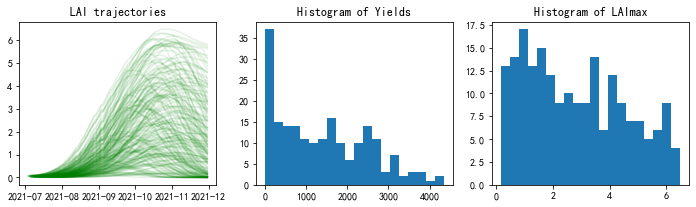

In [68]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axs = axs.flatten()
# res_wll = np.load('data/out/ensMaizeWLLverC_2021_-0.70_9.50_size200.npz',allow_pickle=True)
for i in range(res['LAI'].shape[0]):
    axs[0].plot(res['sim_times'], res['LAI'][i],alpha=0.1,color = 'g')

axs[0].set_title('LAI trajectories')
axs[1].hist(res['Yields'], bins=20)
axs[1].set_title('Histogram of Yields')
axs[2].hist(np.nanmax(res['LAI'],axis=1), bins=20)
axs[2].set_title('Histogram of LAImax')